# Машинное обучение, ФКН ВШЭ

# Практическое задание 2

## Общая информация

Дата выдачи: 11.10.2016

Срок сдачи: 24.10.2016 23:59MSK

### О задании
На сайтах для поиска работы можно найти сотни тысяч объявлений, каждое из которых состоит из пространного описания вакансии и предлагаемой зарплаты. Есть ли связь между описанием и зарплатой? Существуют ли определенные слова, которые наиболее сильно характеризуют зарплату? Можно ли найти другие информативные факторы? Вам предстоит ответить на эти вопросы, проанализировав выборку объявлений о работе в Великобритании.

Практическое задание 2 посвящено работе с текстовыми данными и категориальными признаками и задачам бинарной классификации. Вы научитесь:
 * работать с категориальными признаками;
 * строить вещественные представления текстовых данных;
 * обучать и строить прогнозы линейных классификаторов при помощи scikit-learn и Vowpal Wabbit;
 * тестировать модели и проводить оценку качества в задачах бинарной классификации.


### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Кроме того, некоторые из заданий являются опциональными (необязательными), однако за их выполнение можно получить дополнительные баллы, которые позднее будут учитываться при проставлении оценок автоматом по курсу.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW2_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW2_IvanovII.ipynb*). Далее отправьте этот файл на hse.cs.ml+<номер группы>@gmail.com (например, hse.cs.ml+141@gmail.com для студентов группы БПМИ-141).

## Данные

Как было упомянуто ранее, в рамках данного задания мы будем решать задачу бинарной классификации для предсказания уровня заработной платы по тексту объявления о вакансии на примере набора данных с соревнования [Adzuna - Job Salary Prediction](https://www.kaggle.com/c/job-salary-prediction). Для начала пройдите по [ссылке](https://www.kaggle.com/c/job-salary-prediction/data) и скачайте файл Train_rev1 (при необходимости, зарегистрируйтесь на Kaggle).

Посмотрим на данные в файле и загрузим их в DataFrame:

In [63]:
%pylab inline

import numpy as np
import pandas as pd
%matplotlib inline
import math
from sklearn import preprocessing, feature_extraction, linear_model, metrics, feature_extraction, model_selection
import matplotlib
from scipy.sparse import hstack, csr

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/miniconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['hstack', 'median']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [64]:
# print first 2 rows from Train_rev1.csv
!head -n 2 Train_rev1.csv

In [149]:
df = pd.read_csv('Train_rev1.csv', sep=',')
print df.shape
df.head()

(244768, 12)


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


В оригинальной постановке предлагается рассматривать признак SalaryNormalized как целевой и решать задачу регрессии, однако в рамках данного задания мы сведём её к задаче бинарной классификации, разделив объекты на 2 группы: объявления о вакансиях с низкой и высокой зарплатами соответственно.

<img src = "http://salt.uaa.alaska.edu/kath/kti/mean_median2.gif">

В качестве порога разбиения объектов на группы будем рассматривать медиану признака SalaryNormalized. Заметим, что таким образом мы автоматически получим задачу классификации со сбалансированными классами:

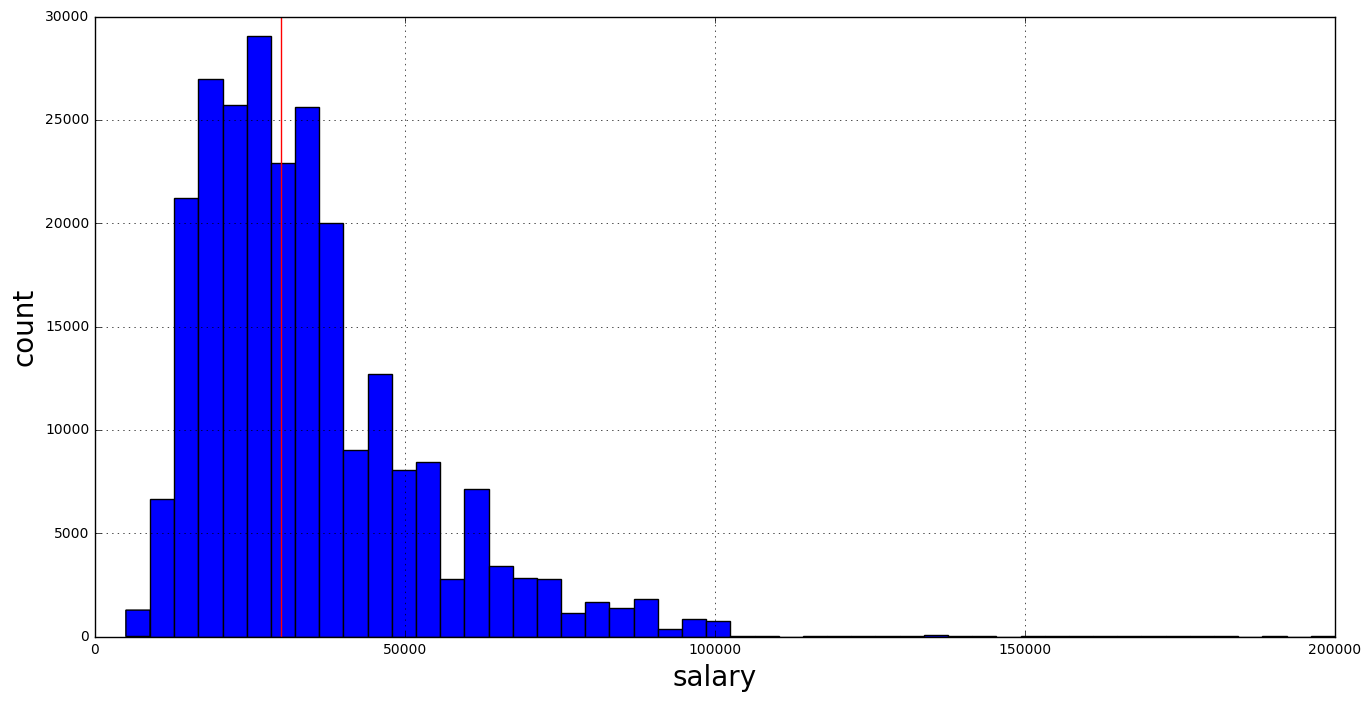

In [150]:
# salary histogramm
median = np.median(df['SalaryNormalized'])

figsize(16,8)
plt.hist(df['SalaryNormalized'], bins=50)
plt.axvline(median, c='r')
plt.xlabel('salary', fontsize=20)
plt.ylabel('count', fontsize=20)
plt.grid()

Осуществим последние шаги по подготовке датасета:
- бинаризуем признак SalaryNomalized по описанному ранее порогу;
- исключим из выборки признак SalaryRaw, чтобы устранить утечку целевой переменной в признаки.

In [151]:
df['SalaryNormalized'] = (df['SalaryNormalized'] > median).astype(int)
df.drop('SalaryRaw', axis=1, inplace=True)
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk


#### 1. (0 баллов) Разбейте получившуюся выборку на обучающую и контрольную в соотношении 70/30 с использованием перемешивания объектов.

При разбиении используйте значение параметра random_state=42.

In [152]:
df = df.reindex(np.random.permutation(df.index))

In [153]:
y = df["SalaryNormalized"]
# y.head()

In [154]:
df.drop("SalaryNormalized", axis=1, inplace=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(df, y, test_size=0.3, random_state=42)

In [155]:
# print X_train.shape, y_test.shape
y_train = y_train.reset_index()
y_test = y_test.reset_index()

## Векторизация

Как правило, модели, используемые в машинном обучении, применяются в предположении, что матрица "объект-признак" является вещественнозначной. Поэтому при работе с категориальными признаками и текстами сперва их необходимо привести к вещественному виду.

Заметим, что в нашей задаче есть признаки, являющиеся текстами произвольной природы (Title, FullDescription), и категориальные признаки, принимающие ограниченное число значений (ContractType, Category и др.).

Самый простой и понятный способ преобразования текстовых данных — векторизация. В этом случае для каждого слова, встречающегося в некотором набре текстов мы создаём отдельный новый признак, который будет равен $1$, когда слово встречается в заданном объекте, и $0$ – в противном случае.

#### 2. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, осуществив векторизацию получившихся текстов при помощи [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

In [156]:
X_train = X_train.replace(np.nan, ' ', regex=True)
X_test = X_test.replace(np.nan, ' ', regex=True)

X_train["Desc"] = X_train["Title"] + " " + X_train["FullDescription"] + " " + X_train["LocationRaw"] + " " + X_train["LocationNormalized"] + " " + X_train["ContractType"] + " " + X_train["ContractTime"] + " " + X_train["Company"] + " " + X_train["Category"]
X_test["Desc"] = X_test["Title"] + " " + X_test["FullDescription"] + " " + X_test["LocationRaw"] + " " + X_test["LocationNormalized"] + " " + X_test["ContractType"] + " " + X_test["ContractTime"] + " " + X_test["Company"] + " " + X_test["Category"]

In [157]:
%%time
vectorizer = feature_extraction.text.CountVectorizer(binary=True)
X_train_bag = vectorizer.fit_transform(X_train["Desc"])


CPU times: user 45.5 s, sys: 340 ms, total: 45.8 s
Wall time: 45.8 s


In [158]:
X_train_bag

<171337x169080 sparse matrix of type '<type 'numpy.int64'>'
	with 25239728 stored elements in Compressed Sparse Row format>

In [159]:
%%time
X_test_bag = vectorizer.transform(X_test["Desc"])
# X_test_bag
# df[7:10]

CPU times: user 20.3 s, sys: 43.8 ms, total: 20.3 s
Wall time: 20.3 s


#### 3. (1.5 балла) Обучите следующие модели на обучающей выборке:
 - [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
 - логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

In [160]:
%%time
lr = linear_model.LogisticRegression(n_jobs=16)
lr = lr.fit(X_train_bag, y_train["SalaryNormalized"])

CPU times: user 15min 10s, sys: 42 s, total: 15min 52s
Wall time: 2min


In [161]:
prob_pred_lr = lr.predict_proba(X_test_bag)
class_pred_lr = lr.predict(X_test_bag)

In [162]:
def build_vw_data(filename, X_vect, y):
    f = open(filename, "w")
    for i in range(X_vect.shape[0]):
        vw_raw = str(1 if y.loc[i]["SalaryNormalized"] else -1) + " |features"
        for feature in range(X_vect.indptr[i], X_vect.indptr[i+1]):
            vw_raw += " " + str(X_vect.indices[feature]) + ":" + str(float(X_vect.data[feature]))
        vw_raw += "\n"
        f.write(vw_raw)
    f.close()

In [163]:
%%time
build_vw_data("train.vw", X_train_bag, y_train)
build_vw_data("test.vw", X_test_bag, y_test)


CPU times: user 3min 32s, sys: 878 ms, total: 3min 33s
Wall time: 3min 32s


In [177]:
%%time
!vw -d train.vw --loss_function=logistic --readable_model solution.txt -f solution.vw

final_regressor = solution.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0   1.0000   0.0000      166
0.562375 0.431603            2            2.0   1.0000   0.6167      144
0.755681 0.948988            4            4.0  -1.0000   0.5485      147
0.773917 0.792153            8            8.0  -1.0000   0.0104      161
0.730096 0.686274           16           16.0   1.0000   0.0372      155
0.708426 0.686757           32           32.0   1.0000   0.3150      152
0.691267 0.674108           64           64.0  -1.0000  -0.1901       97
0.616030 0.540793          128          128.0   1.0000   0.1891      138
0.597382 0.578735          256          256.0  -1.0000  -1.5284      188
0.546139 0.494896          512         

In [165]:
!vw -d test.vw -t -i solution.vw --link=logistic -p probs.vw

only testing
predictions = probs.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
7.209320 7.209320            1            1.0  -1.0000   0.0245      116
5.652769 4.096219            2            2.0  -1.0000   0.0464       55
5.567798 5.482826            4            4.0   1.0000   0.9492      164
3.158350 0.748902            8            8.0   1.0000   0.7961      191
4.464632 5.770914           16           16.0  -1.0000   0.3514      133
8.234938 12.005243           32           32.0   1.0000   0.5734      225
6.524411 4.813884           64           64.0  -1.0000   0.5713      137
6.345851 6.167291          128          128.0   1.0000   0.6126      182
5.256483 4.167115          256          256.0  -1.0000   0.7095       97
5.315632 5.374781          512   

In [166]:
!vw -d test.vw -t -i solution.vw --binary -p pred.vw 

only testing
predictions = pred.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  -1.0000  -1.0000      116
0.000000 0.000000            2            2.0  -1.0000  -1.0000       55
0.000000 0.000000            4            4.0   1.0000   1.0000      164
0.125000 0.250000            8            8.0   1.0000   1.0000      191
0.187500 0.250000           16           16.0  -1.0000  -1.0000      133
0.125000 0.062500           32           32.0   1.0000   1.0000      225
0.156250 0.187500           64           64.0  -1.0000   1.0000      137
0.132812 0.109375          128          128.0   1.0000   1.0000      182
0.136719 0.140625          256          256.0  -1.0000   1.0000       97
0.119141 0.101562          512     

#### 4. (0.5 балла) Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 3 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

In [167]:
#sklearn
print "AUC-ROC:", metrics.roc_auc_score(y_test["SalaryNormalized"], prob_pred_lr[:,1])
print "F-measure:", metrics.f1_score(y_test["SalaryNormalized"], class_pred_lr)
print metrics.confusion_matrix(y_test["SalaryNormalized"], class_pred_lr)

AUC-ROC: 0.943194169311
F-measure: 0.871273541973
[[33127  4567]
 [ 4626 31111]]


In [168]:
#vw
prob_pred_vw = pd.read_csv("probs.vw", names=["PROB"], header=None)
class_pred_vw = pd.read_csv("pred.vw", header=None, names=["PRED"])
class_pred_vw.ix[class_pred_vw.PRED == -1, "PRED"] = 0
print "AUC-ROC:", metrics.roc_auc_score(y_test["SalaryNormalized"], prob_pred_vw)
print "F-measure:", metrics.f1_score(y_test["SalaryNormalized"], class_pred_vw)
print metrics.confusion_matrix(y_test["SalaryNormalized"], class_pred_vw)

AUC-ROC: 0.935708526826
F-measure: 0.856276958642
[[32862  4832]
 [ 5364 30373]]


Оба результата очень хорошие. Метрика AUC-ROC оценивает приятнее F-меры, так что если уж показывать боссу результат, то использовать её. По всем показателям логистическая регрессия лучше обучилась у sklearn. В том числе и ошибок FP FN меньше дал на тестовой выборке sklearn. Вообще vw тоже норм, учитывая скорость обучения, результаты получились отличные. 

#### 5. (1 балл) Отсортируйте веса признаков для модели логистической регрессии из scikit-learn, полученной в п. 2. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретируйте полученный результат.

In [147]:
def get_sorted_words(coefs, word_names):
    pos_weights = []
    neg_weights = []
    for i in range(coefs.shape[1]):
        pos_weights.append([i, coefs[0][i]]) if coefs[0][i] > 0 else neg_weights.append([i, coefs[0][i]])

    pos_weights = sorted(pos_weights, key=lambda x: x[1]) #по возрастанию веса
    neg_weights = sorted(neg_weights, key=lambda x: -x[1]) #по убыванию веса


    print "САМЫЕ весомые вверх:\n"
    for i in range(20):
        print word_names[pos_weights[- i - 1][0]]

    print "САМЫЕ весомые вниз:\n"
    for i in range(20):
        print word_names[neg_weights[- i - 1][0]]

    print "САМЫЕ не весомые вверх и вниз:\n"
    for i in range(10):
        print word_names[pos_weights[i][0]], ">up"
        print word_names[neg_weights[i][0]], "<down"


    

In [148]:
get_sorted_words(lr.coef_, vectorizer.get_feature_names())

САМЫЕ весомые вверх:

a24
optometrist
noreen
nhsd
rca
offender
hcpc
aura
interestfree
judge
synopsis
apl
gscc
mcx
denote
webrecruit
nikky
keyaccountmanager_job
hypermill
coping
САМЫЕ весомые вниз:

bv
studentship
ktp
mentored
phocas
iqpc
omar
pune
surrounds
mller
cpcs
pthr
jobsitnmark
expose
bistro
jamesfosterkvrecruitment
reidliquidpersonnel
guard
allocator
mikaela
САМЫЕ не весомые вверх и вниз:

nvqassessorhealthandsocialcarenorthwest >up
poisonous <down
cleaneratwinsfordindustrialestate_job >up
juniorsousrequiredfor <down
quinplex >up
rosettehotelinchichester <down
etworks >up
combpany <down
iscovery >up
1565 <down
ligible >up
bishopswood <down
mpto >up
cashup <down
applicationdevelopmentmanager_job >up
cholmeley <down
reverted >up
highgateschool <down
stockgrove >up
highlyconsultative <down


Результаты получились логичные. Зарплату значительно повышают разные начальники, менеджеры, судьи, hcpс(Health and Care Professions Council), вообщем специалисты. Понижают слова вроде бистро, помошник, стажер, сторож, клерк и прочие. Незначительное влияние имеют "битые" слова и общеупотребимые, обычно не несущие никакой конкретики, а так же прилагательные(они обычно употребляются во всех объявлениях независимо от зарплаты).

#### 6. (0.5 доп. балла) Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 2 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [182]:
sol = pd.read_csv("solution.txt", sep=":", skiprows=11, header=None, names=["id", "w"])

In [184]:
get_sorted_words(np.array([sol["w"]]), vectorizer.get_feature_names())

САМЫЕ весомые вверх:

optometrist
hcpc
locum
london
manager
lawyer
dba
solicitor
director
senior
gmc
jobg8
lecturer
aca
smsts
pqe
head
realstaffing
recrutiment
avp
САМЫЕ весомые вниз:

assistant
partie
graduate
cleaner
labourer
cpcs
aat
graduates
coordinator
de
administrator
clerk
nvq
commis
junior
adecco
operative
tacho
paralegal
unloading
САМЫЕ не весомые вверх и вниз:

sectorthis >up
rotalocation <down
unreal >up
turnerandtownsend <down
arisen >up
highlyfocused <down
stevedores >up
bonusan <down
indemand >up
connect4 <down
beer >up
tecnician <down
specificationthe >up
acess <down
alsager >up
mysqlhtml <down
ageing >up
jobsharing <down
eecs >up
downturns <down


Тут поменьше мусора, но результат вцелом очень похож на предыдущий.
manager
lawyer
solicitor
director
senior pomidor
gmc
lecturer
тут и директор и мееджер и дженерал моторс, все эти слова имеют высокое влияние на классификацию 1.
Разная прислуга, асистенты вроде assistant, планктон (clerk commis), выпускники получают, занятые частично (unloading, partie) имеют маленькую зарплату.
Редкие слова имеют вес около нуля.
Интерестно, в каком контексте употреблялось слово пиво? Погляжу на досуге... 

## TF-IDF

Ещё один способ работы с текстовыми данными — [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf) (**T**erm **F**requency–**I**nverse **D**ocument **F**requency). Рассмотрим коллекцию текстов $D$.  Для каждого уникального слова $t$ из документа $d \in D$ вычислим следующие величины:

1. Term Frequency – количество вхождений слова в отношении к общему числу слов в тексте:
$$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$
где $n_{td}$ — количество вхождений слова $t$ в текст $d$.
1. Inverse Document Frequency
$$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$
где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.

Тогда для каждой пары (слово, текст) $(t, d)$ вычислим величину:
$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

Отметим, что значение $\text{tf}(t, d)$ корректируется для часто встречающихся общеупотребимых слов при помощи значения $\text{idf}(t, D).$

Признаковым описанием одного объекта $d \in D$ будет вектор $\bigg(\text{tf-idf}(t,d, D)\bigg)_{t\in V}$, где $V$ – словарь всех слов, встречающихся в коллекции $D$.

#### 7. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, вычислив вектор tf-idf для каждого объекта помощи [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

In [88]:
%%time
tfidf_vectorizer = feature_extraction.text.TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["Desc"])
X_test_tfidf = tfidf_vectorizer.transform(X_test["Desc"])

CPU times: user 1min 6s, sys: 548 ms, total: 1min 7s
Wall time: 1min 6s


#### 8. (0 баллов) Обучите следующие модели на обучающей выборке:
- [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
- логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

In [89]:
%%time
lr_tfidf = linear_model.LogisticRegression(n_jobs=16)
lr_tfidf = lr_tfidf.fit(X_train_tfidf, y_train["SalaryNormalized"])

prob_pred_lr_tfidf = lr_tfidf.predict_proba(X_test_tfidf)
class_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)

CPU times: user 1min 58s, sys: 5.5 s, total: 2min 4s
Wall time: 15.8 s


In [90]:
%%time
build_vw_data("train_tfidf.vw", X_train_tfidf, y_train)
build_vw_data("test_tfidf.vw", X_test_tfidf, y_test)

CPU times: user 3min 39s, sys: 1.76 s, total: 3min 41s
Wall time: 3min 39s


In [178]:
%%time
!vw -d train_tfidf.vw --loss_function=logistic --readable_model solution_tfidf.txt -f solution_tfidf.vw

final_regressor = solution_tfidf.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = train_tfidf.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.0000      185
0.641500 0.589852            2            2.0  -1.0000  -0.2185      136
0.769773 0.898046            4            4.0  -1.0000  -0.3530      121
0.711979 0.654185            8            8.0   1.0000   0.0507      197
0.641785 0.571591           16           16.0   1.0000   1.3538      209
0.677175 0.712566           32           32.0   1.0000   0.4920      153
0.663551 0.649927           64           64.0  -1.0000  -0.2396       98
0.621380 0.579209          128          128.0  -1.0000   1.0144      116
0.595383 0.569385          256          256.0  -1.0000   0.0189      134
0.570422 0.545462          

In [92]:
!vw -d test_tfidf.vw -t -i solution_tfidf.vw --link=logistic -p probs_tfidf.vw

only testing
predictions = probs_tfidf.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = test_tfidf.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.089809 0.089809            1            1.0  -1.0000   0.2142       30
0.058670 0.027531            2            2.0   1.0000   0.7624      188
2.617105 5.175540            4            4.0   1.0000   0.9630      252
5.082897 7.548689            8            8.0  -1.0000   0.0023      205
3.629958 2.177018           16           16.0   1.0000   0.8646      148
3.215963 2.801968           32           32.0   1.0000   0.6696      153
3.168265 3.120567           64           64.0  -1.0000   0.0537       40
3.348703 3.529141          128          128.0  -1.0000   0.0596      197
4.203251 5.057798          256          256.0  -1.0000   0.0701      165
4.344501 4.485752     

In [93]:
!vw -d test_tfidf.vw -t -i solution_tfidf.vw --binary -p pred_tfidf.vw 

only testing
predictions = pred_tfidf.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = test_tfidf.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  -1.0000  -1.0000       30
0.000000 0.000000            2            2.0   1.0000   1.0000      188
0.250000 0.500000            4            4.0   1.0000   1.0000      252
0.250000 0.250000            8            8.0  -1.0000  -1.0000      205
0.125000 0.000000           16           16.0   1.0000   1.0000      148
0.093750 0.062500           32           32.0   1.0000   1.0000      153
0.140625 0.187500           64           64.0  -1.0000  -1.0000       40
0.156250 0.171875          128          128.0  -1.0000  -1.0000      197
0.144531 0.132812          256          256.0  -1.0000  -1.0000      165
0.146484 0.148438      

#### 9. (0.5 балла) Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 8 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

In [94]:
#sklearn
print "AUC-ROC:", metrics.roc_auc_score(y_test["SalaryNormalized"], prob_pred_lr_tfidf[:,1])
print "F-measure:", metrics.f1_score(y_test["SalaryNormalized"], class_pred_lr_tfidf)
print metrics.confusion_matrix(y_test["SalaryNormalized"], class_pred_lr_tfidf)

AUC-ROC: 0.940866177403
F-measure: 0.863874052739
[[32802  5045]
 [ 4691 30893]]


In [95]:
#vw
prob_pred_vw_tfidf = pd.read_csv("probs_tfidf.vw", names=["PROB"], header=None)
class_pred_vw_tfidf = pd.read_csv("pred_tfidf.vw", header=None, names=["PRED"])
class_pred_vw_tfidf.ix[class_pred_vw_tfidf.PRED == -1, "PRED"] = 0
print "AUC-ROC:", metrics.roc_auc_score(y_test["SalaryNormalized"], prob_pred_vw_tfidf)
print "F-measure:", metrics.f1_score(y_test["SalaryNormalized"], class_pred_vw_tfidf)
print metrics.confusion_matrix(y_test["SalaryNormalized"], class_pred_vw_tfidf)

AUC-ROC: 0.944941134584
F-measure: 0.868856826372
[[33095  4752]
 [ 4601 30983]]


vw модель показала лучший результат по всем метрикам. И площадь и гармоническое среднее pres и rec незначительно выше у модели vw. Ошибок FP FN так же меньше у vw.

#### 10. (0.5 балла) Сравните значения метрик из п. 9 со значениями, полученными в п. 5, и сравните соответствующие модели по качеству из работы.

**Ответ**:

В случае sklearn бинарная векторизация сработала чуть лучше чем tf-idf кодирование по всем метрикам.
В случае vw ситуация обратная: показатели по всем метрикам при tf-idf кодировании здесь лучше.
Разница вцелом соизмерима для всех случаев - auc-roc и f-мера отличаются на ~10-15 тысячных. Количество ошибок плавает от 200 до 600, что вцелом незначительно, учитывая количество правильных ответов и размер выборки вцелом.
Таким образом, для бинарной векторизации лучше работает модель sklearn, vw же пригодится при tf-idf кодировании признаков.

#### 11. (1 балл) Отсортируйте веса признаков для модели sclearn. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [96]:
get_sorted_words(lr_tfidf.coef_, tfidf_vectorizer.get_feature_names())

САМЫЕ весомые вверх:

optometrist
director
manager
senior
head
london
locum
hcpc
leadership
lead
САМЫЕ весомые вниз:

assistant
graduate
junior
nvq
administrator
aat
assistants
telephone
partie
technician
САМЫЕ не весомые вверх и вниз:

parttimeadminassistant_job >up
nonscheduled <down
unaware >up
administrationreceptionistaccountsassistant_job <down
accountsassistantadministrationassistantparttime_job >up
lcci <down
itops >up
twitter <down
standardswith >up
outbased <down
tmtseniorstrategymanager_job >up
esh <down
adminassistant_job >up
accountsassistantledgerclerksagecroydon <down
principalservicemanagerservicedirector_job >up
cousldon <down
mcap >up
backings <down
mobileenabled >up
recruitmentmulti <down


Все из по той же схеме: лондон(дороговато там), синьер, главный, директор - имеют большой вес при определении положительного класса.
Помошник, джуниор, стажировка, телефон, выпускник - увеличивают расстояние от положительного класса.
Всякий мусор и слова, которые редко встречаются, имеют незначительное влияние, как и в прошлый раз.

#### 12. (0.5 доп. балла) Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 8 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [186]:
sol_tf_idf = pd.read_csv("solution_tfidf.txt", sep=":", skiprows=11, header=None, names=["id", "w"])
get_sorted_words(np.array([sol_tf_idf["w"]]), tfidf_vectorizer.get_feature_names())

САМЫЕ весомые вверх:

quqlification
strictlylegal
strictly_legal
spectacle
cvbar
unloved
underappreciated
technicalsalesmanagerpigmentsfillerstosurfacecoatings_job
plastice
atrsolutions
porto
dsfrecruitmentrac
yasminpeoplewithchemistry
lipman
gibsonnoirconsulting
navisionjobs
simonbath
clarkredsnappergroup
braga
nigelfrank
САМЫЕ весомые вниз:

hearingcareflamehealth
spoton
yearscoring
spkcfl
_6
stanforth
vintageinn
airmonitoring
vehiclepurchasercarsales_job
fortyeight
dripping
drizzling
msonormal
margintop
marginright
_24
_2
dvds
assistant
emberpubanddining
САМЫЕ не весомые вверх и вниз:

assay >up
papdale <down
kieran >up
horizontal <down
jobco >up
electricial <down
sweat >up
autocoding <down
bentleyjenrick >up
certcii <down
dd2 >up
forth <down
yep >up
mrc <down
psa >up
herfordshire <down
nonstock >up
gyfrifol <down
publicise >up
shade <down


Снова видим суперлегальных менеджеров и, правда, много новых слов, которые редко встречаются, однако, их объявления  имеют высокую вероятность большой зарплаты.
Сильно понижают вероятность слова assistant и 45(видно слишком старый)
Слабое влияние имеют слова общеупотребляемые, бесполезные для классификации.
Вообще это самый <strike>неадекватный</strike> интересный вывод этого задания из всех четырех, возможно что-то съехало, пора сдаваться.



## Счётчики

Ранее в рамках данного задания при построении моделей мы объединяли значения всех признаков в единую строку, что предполагает равноправность всех признаков. Однако заметим, что в этом случае мы допускаем потерю информации: слово "Glasgow" может по-разному влиять на зарплату, если оно находится в названии объявления и в геолокации. Чтобы устранить этот недостаток, при создании текстового описания объекта будем объединять только значения признаков Title и FullDescription, а остальные будем рассматривать как категориальные. При этом с полученным текстовым описанием объекта будем работать, как раньше (при помощи векторизации или tf-idf), а для кодирования категориальных признаков используем **счётчики**.

Идея этого метода состоит в том, чтобы заменить значение категориального признака на вероятность того, что объект с данным значением признака относится к положительному классу. Опишем эту идею более формально. Пусть у нас есть выборка $X = \{ (x_i, y_i) \}_{i=1}^l,$ и $j$-ый признак принимает значения из множества $U_j = \{ u_{jn}\}_{n=1}^{N_j},$ где $N_j$ — количество различных значений $j$-ого признака. Пусть $x_{ij} = u_{jn},$ тогда заменим значения $j$-ого категориального признака объекта $x_i$ на следующую оценку: 
$$\hat{P}(y_i=+1|x_{ij}=u_{jn}) = \frac{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right]}.$$

Однако заметим, что при таком способе формирования счётчиков мы учитываем в формуле для объекта $x_i$ его метку $y_i$, тем самым вносим информацию об ответе в признаки. Чтобы устранить этот недостаток, при вычислении счётчика будем исключать из рассмотрения текущий объект, т.е. рассматривать следующую оценку:
$$\hat{P}(y_i=+1|X_{ij}=u_{jn}) = \frac{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right]},$$

#### 13. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения признаков Title и FullDescription каждого объекта выборки через символ пробела, после чего перейдите к признаковому описанию объектов, вычислив вектор tf-idf аналогично п. 7.

In [119]:
X_train = X_train.fillna('nan')
X_test = X_test.fillna('nan')
df = df.fillna('nan')

In [99]:
%%time
X_train["Desc"] = X_train["Title"] + " " + X_train["FullDescription"]
X_test["Desc"] = X_test["Title"] + " " + X_test["FullDescription"]
num_tfidf_vectorizer = feature_extraction.text.TfidfVectorizer()
X_train_num_tfidf = num_tfidf_vectorizer.fit_transform(X_train["Desc"])
X_test_num_tfidf = num_tfidf_vectorizer.transform(X_test["Desc"])

CPU times: user 1min 3s, sys: 364 ms, total: 1min 3s
Wall time: 1min 3s


#### 14. (1 балл) Закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи [one-hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке. 

In [120]:
df["Desc"] = 0

In [121]:
X_test.head(1)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName
174861,71435627,Digital Marketing Manager,The Digital Marketing Manager is responsible f...,Birmingham West Midlands (County) West Midlands,UK,nan,permanent,Michael Page Marketing,"PR, Advertising & Marketing Jobs",totaljobs.com


In [122]:
X_test.shape

(73431, 10)

In [123]:
df.shape

(244768, 11)

In [125]:
%%time
data_features_mask = [False, False, False, True, True, True, True, True, True, True, False]
# X_train = X_train.fillna('nan')
# X_test = X_test.fillna('nan')
# df = df.fillna('nan')
label_enc = preprocessing.LabelEncoder()
for feature in df.columns[data_features_mask]:
    df[feature] = label_enc.fit_transform(df[feature])
    X_train[feature] = label_enc.transform(X_train[feature])
    X_test[feature] = label_enc.transform(X_test[feature])



CPU times: user 250 ms, sys: 80 µs, total: 250 ms
Wall time: 249 ms


In [126]:
OneHot = preprocessing.OneHotEncoder()
OneHot.fit(df[df.columns[data_features_mask]])
X_train_onehot_s_mtx = OneHot.transform(X_train[X_train.columns[data_features_mask]])
X_test_onehot_s_mtx = OneHot.transform(X_test[X_test.columns[data_features_mask]])

/home/ubuntu/miniconda/lib/python2.7/site-packages/pandas/indexes/base.py:1404: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 11
  result = getitem(key)


In [127]:
%%time


lr_tfidf_mixed_onehot = linear_model.LogisticRegression(n_jobs=16)
lr_tfidf_mixed_onehot.fit(hstack((X_train_num_tfidf, X_train_onehot_s_mtx)), y_train["SalaryNormalized"])

prob_pred_lr_tfidf_mixed_onehot = lr_tfidf_mixed_onehot.predict_proba(hstack((X_test_num_tfidf, X_test_onehot_s_mtx)))
class_pred_lr_tfidf_mixed_onehot = lr_tfidf_mixed_onehot.predict(hstack((X_test_num_tfidf, X_test_onehot_s_mtx)))

CPU times: user 7min 47s, sys: 21.2 s, total: 8min 8s
Wall time: 1min 11s


In [128]:
#sklearn
print "AUC-ROC:", metrics.roc_auc_score(y_test["SalaryNormalized"], prob_pred_lr_tfidf_mixed_onehot[:,1])
print "F-measure:", metrics.f1_score(y_test["SalaryNormalized"], class_pred_lr_tfidf_mixed_onehot)
print metrics.confusion_matrix(y_test["SalaryNormalized"], class_pred_lr_tfidf_mixed_onehot)

AUC-ROC: 0.834544651967
F-measure: 0.748389795065
[[28542  9273]
 [ 8775 26841]]


#### 15. (2 балла) Для выборки, полученной в п. 13, закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи счётчиков, после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке. 

Уделите внимание оптимальности вычисления счётчиков!

In [129]:
X_train = X_train.reset_index()

In [130]:
X_test = X_test.reset_index()

In [131]:
X_train.head(1)

,index,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName
0,198646,71848687,Sales Executive,Would you like to work for one of the nations ...,17602,2448,1,2,4905,23,159


In [132]:
X_train["target"] = y_train["SalaryNormalized"]

In [133]:
X_test["target"] = y_test["SalaryNormalized"]

In [135]:
def set_feature_probs(feature, X, feature_count):
    adt_mtx = np.array([[(X[X[feature] == i].shape[0] - 1), (X[(X[feature] == i) & (X["target"])].shape[0]), 0] for i in range(feature_count + 1)], dtype=float) # i|количество прин i - 1|колич +1 
    for i in adt_mtx:
        if i[0] == 0:
            i[2] = 0
            i[0] = 9999999999999990
        else:
            i[2] = (i[1] / i[0])
    X[feature] = X.apply(lambda x: adt_mtx[x[feature]][2] - ((1 / adt_mtx[x[feature]][0]) if x["target"] else 0), axis = 1)
    return X[feature]

In [136]:
features_s = ["LocationRaw", "LocationNormalized", "ContractType", "ContractTime", "Company", "Category", "SourceName"]

In [137]:
%%time
for feature in features_s:
    X_train[feature] = set_feature_probs(feature, X_train, df[feature].max())

CPU times: user 3min 5s, sys: 356 ms, total: 3min 6s
Wall time: 3min 5s


In [138]:
%%time
for feature in features_s:
    X_test[feature] = set_feature_probs(feature, X_test, df[feature].max())

CPU times: user 1min 59s, sys: 176 ms, total: 1min 59s
Wall time: 1min 59s


In [139]:
X_test.head(1)

,index,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName,target
0,174861,71435627,Digital Marketing Manager,The Digital Marketing Manager is responsible f...,0.487059,0.482243,0.518541,0.538404,0.7,0.556101,0.437591,1


In [140]:
X_train_num_num_s_mtx = X_train[features_s].to_sparse()

In [141]:
X_test_num_num_s_mtx = X_test[features_s].to_sparse()

In [142]:
X_train_num_num_s_mtx = csr.csr_matrix(X_train_num_num_s_mtx)

In [143]:
X_test_num_num_s_mtx = csr.csr_matrix(X_test_num_num_s_mtx)

In [144]:
%%time
lr_tfidf_mixed_num = linear_model.LogisticRegression(n_jobs=16)
lr_tfidf_mixed_num.fit(hstack((X_train_num_tfidf, X_train_num_num_s_mtx)), y_train["SalaryNormalized"])

prob_pred_lr_tfidf_mixed_num = lr_tfidf_mixed_num.predict_proba(hstack((X_test_num_tfidf, X_test_num_num_s_mtx)))
class_pred_lr_tfidf_mixed_num = lr_tfidf_mixed_num.predict(hstack((X_test_num_tfidf, X_test_num_num_s_mtx)))

CPU times: user 3min 20s, sys: 8.71 s, total: 3min 29s
Wall time: 37.5 s


In [145]:
#sklearn
print "AUC-ROC:", metrics.roc_auc_score(y_test["SalaryNormalized"], prob_pred_lr_tfidf_mixed_num[:,1])
print "F-measure:", metrics.f1_score(y_test["SalaryNormalized"], class_pred_lr_tfidf_mixed_num)
print metrics.confusion_matrix(y_test["SalaryNormalized"], class_pred_lr_tfidf_mixed_num)

AUC-ROC: 0.810118086837
F-measure: 0.724921485313
[[28568  9247]
 [10110 25506]]


#### 16. (0.5 балла) Сравните значения метрик из п. 15 со значениями, полученными в п. 14, и сделайте вывод о качестве классификации для каждого из методов кодирования категориальных признаков.

**Ответ:**

Кодирование с onehot показало лучшее качество по всем метрикам в сравнении с моей реалиацией счетчиков. Отличие AUC-ROC и f-мера ниже на 1-2 сотых, что может быть связано не только с самим методом, но и с тем что кодирование производилось согласно всей выборке. В то время как мои счетчики устанавливались независимо для обучения и теста. Так можно сделать благодаря размерам и высокой сбалансированности выборок, не без потерь, конечно.
При использовании счетчиков, классификатор стал много ошибаться определяя положительные объекты как отрицательные.
На основе полученных результатов можно сделать вывод о том, что tf-idf + onehot кодирование работает для нашей задачи классификации лучше чем tf-idf + счетчики. 

## Подбор гиперпараметров

#### 17. (1.5 доп. балла) Разбейте обучающую выборку на обучающую и валидационную в отношении 80/20. Для выборки, полученной в п. 13, подберите оптимальное количество фолдов, используемое при кодировании категориальных признаков (всех, кроме Title и FullDescription), путём оптимизации значения accuracy на валидационной выборке. Используйте следующие модели, аналогично также подобрав оптимальные значения указанных гиперпараметров:
- логистическую регрессию из модуля sklearn с подбором коэффициента регуляризации;
- логистическую регрессию при помощи Vowpal Wabbit с подбором следующих гиперпараметров:
    - коэффициент регуляризации (--l2);
    - количество эпох (--passes);
    - длина градиентного шага (-l);
    - длина N-грамм (--ngram).

In [ ]:
# Your code here

#### 18. (0.5 доп. балла) Обучите указанные выше модели на обучающей выборке для оптимальных значений гиперпараметров, найденных в п. 17, после чего для каждой из моделей вычислите значения ROC-AUC, F-меры, а также постройте матрицу ошибок на контрольной выборке. Как качество классификации при помощи полученных в данном разделе моделей соотносится с моделями, полученными в предыдущих разделах?

In [ ]:
# Your code here

Здесь вы можете поделиться своими мыслями по поводу этого задания.

А здесь — вставить вашу вторую любимую картинку.